# Flight Passenger Predictions

This is a simple example of using an LSTM for predicting the number of monthly flight passengers. The (real) data spans the years 1949-1960, and thus it contains 12x12=144 entries with the number of passengers (in thousands). Your job is to predict the next point(s) in the sequence.

There are several ML packages, which have an LSTM implementation, and probably most widely used are:
* Keras Tensorflow (see e.g. https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
* PyTorch (see e.g. https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

***

Author: Troels Petersen<br>
Date: 13th of May 2023

In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from tqdm import tqdm

In [2]:
# Convert an array of values into a dataset matrix:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Load and prepare dataset:

In [3]:
# Fix random seed for reproducibility:
np.random.seed(42)

# Load the dataset:
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X = t and Y = t + 1, and include the last 5 entries in prediction:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Have a look at the data

In [4]:
trainX.shape, trainY.shape

((90, 5, 1), (90,))

Given an `x` such as:

In [5]:
trainX[15, :, :]

array([[0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312]], dtype=float32)

The goal is to predict the next value of the sequence, we we have stored as:

In [6]:
trainY[15]

0.10424709

In [7]:
# Move to PyTorch tensors:
trainX = torch.tensor(trainX, dtype=torch.float)
trainY = torch.tensor(trainY, dtype=torch.float)
testX = torch.tensor(testX, dtype=torch.float)
testY = torch.tensor(testY, dtype=torch.float)

## Make an LSTM model:

In [8]:
class Net(nn.Module):
    def __init__(self, hidden_size=7):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x


net = Net()

## Train the model model:

In [9]:
opt = torch.optim.Adam(net.parameters(), lr=5e-3)
progress_bar = tqdm(range(1000))
for epoch in progress_bar:
    prediction = net(trainX)
    loss = torch.sum((prediction.flatten() - trainY.flatten())**2)
    progress_bar.set_description(f'Loss = {float(loss):6.4f}')
    loss.backward()
    opt.step()
    opt.zero_grad()

Loss = 0.1456: 100%|██████████| 1000/1000 [00:02<00:00, 389.25it/s]


## Inspect the result/performance:

Train Score: 20.83 RMSE
Test Score: 55.80 RMSE


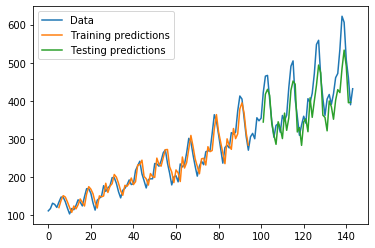

In [10]:
# Make predictions:
with torch.no_grad():
    trainPredict = net(trainX).numpy()
    testPredict = net(testX).numpy()

# Invert predictions:
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY.numpy()])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY.numpy()])

# Calculate root mean squared error:
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions:
plt.plot(scaler.inverse_transform(dataset), label="Data")
plt.plot(trainPredictPlot, label="Training predictions")
plt.plot(testPredictPlot, label="Testing predictions")
plt.legend()
plt.show()

## Exercises:

1. As always, look through the code and convince yourself, that you understand each step.
2. Discuss with your peers, what the input and output to the LSTM looks like, and potentially more advanced datasets.
3. Can you draw the LSTM architecture? And how many parameters does the current model use?
4. The result suggests over-fitting! Play with the LSTM-architechture/training procedure to try to fix this.

## Learning points:

Generally, you should realise, that **time series data** can be analysed with **RNNs, LSTMs, and GRUs**. GRUs are particularly suited for numerical data (as opposted to natural language data).

a. It is - as always - important to inspect the data, and certainly to plot it.<br>
b. One should carefully consider how far back in time input data should be included.<br>
c. One should carefully consider how far into the future the predictions are made.<br>

PS. As this is a purely numerical problem, one should probably have used a GRU instead (simpler, better).
    Note that GRUs can be bi-directional, in case the problem involves a series of data with no obvious direction.